<a href="https://colab.research.google.com/github/athulrj02/DeepDuel/blob/main/ML%7CCA_Two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# pip install tensorflow

In [3]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [4]:
dataset_path = '/content/drive/My Drive/Colab Notebooks/MLPR Images'

In [5]:
# ls dataset folder contents
print(os.listdir(dataset_path))

['Product_1', 'Product_2', 'Product_3', 'Product_4', 'Product_5', 'Background']


In [6]:
# !pip install tensorflow numpy matplotlib opencv-python scikit-learn

In [7]:
class_distribution = {}
for class_folder in os.listdir(dataset_path):
  class_path = os.path.join(dataset_path, class_folder)
  if os.path.isdir(class_path):
    class_distribution[class_folder] = len(os.listdir(class_path))
print('Class Dist',class_distribution)

Class Dist {'Product_1': 500, 'Product_2': 14, 'Product_3': 400, 'Product_4': 385, 'Product_5': 600, 'Background': 39}


#Data Preprocessing

1. Setting Target Image Size: Resizing all images(128,128)
2. Normalize Images: Scaling pixel values to the range [0,1]
3. Spliting dataset: Dividing into training, validation and test sets

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory
# loading the dataset with image resizing and scaling
image_size = (128, 128)
batch_size = 32

In [9]:
# training, validation and test sets
train_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.3,  # 30% for validation and test
    subset="training",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,  # split validation and test from the reserved 30%
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)
test_ds = image_dataset_from_directory(
    dataset_path,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=image_size,
    batch_size=batch_size
)

Found 1938 files belonging to 6 classes.
Using 1357 files for training.
Found 1938 files belonging to 6 classes.
Using 387 files for validation.
Found 1938 files belonging to 6 classes.
Using 193 files for validation.


In [10]:
# normalizing image pixel values
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

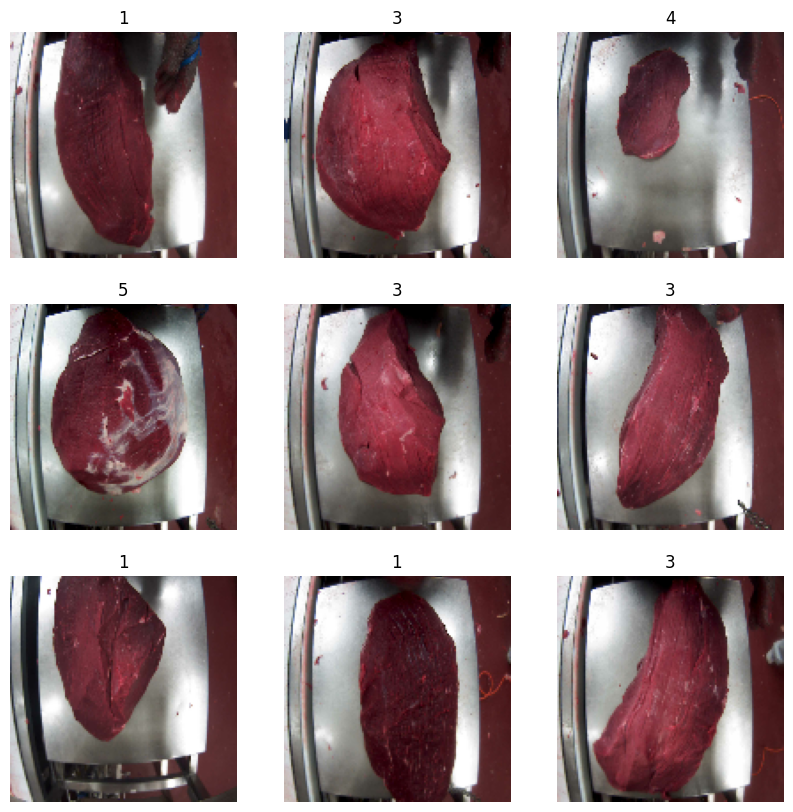

In [11]:
#Visualize sample images
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy())
    plt.title(int(labels[i]))
    plt.axis('off')

#Address class imbalance

In [12]:
# augmenting Underrepresented classes
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [13]:
class_weights = {
    0:1.0,
    1: 5.0,
}

In [14]:
# data augmentation integration
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [15]:
# applying augmentation to the training set
def augment_data(image, label):
    augmented_image = data_augmentation(image)
    return augmented_image, label
train_ds = train_ds.map(lambda x, y: augment_data(x, y))

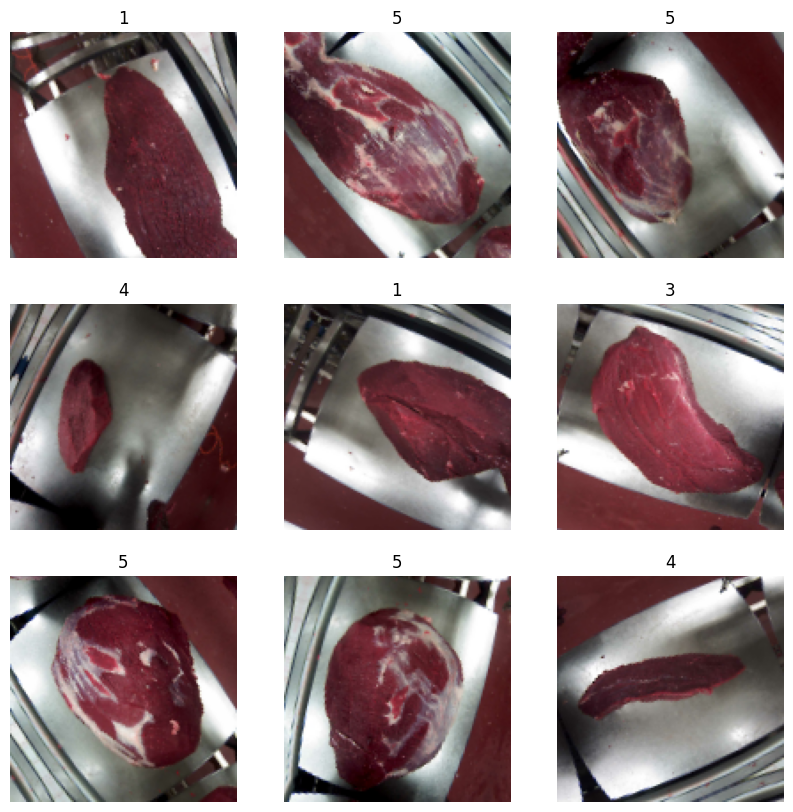

In [16]:
# Visualizing augmented images to verify
for images, labels in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].numpy() * 255).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

#**CNN MODEL**

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [18]:
# Define the CNN model
cnn_model = Sequential([
    # Convolutional Block 1
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 2
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Convolutional Block 3
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),

    # Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')  # Output layer for 6 classes
])

# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
#model summary
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,306,310 (12.61 MB)

 Trainable params: 3,305,862 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [20]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Define the class distribution (from your earlier dataset analysis)
# class_counts = [500, 14, 400, 385, 600, 39]  # Example counts for each class
# class_labels = np.arange(len(class_counts))  # [0, 1, 2, 3, 4, 5]

# # Flatten the labels array based on counts
# y_labels = np.hstack([[label] * count for label, count in enumerate(class_counts)])

# # Compute class weights
# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=class_labels,
#     y=y_labels
# )

# # Convert to dictionary
# class_weights_dict = {label: weight for label, weight in zip(class_labels, class_weights)}
# print("Class Weights:", class_weights_dict)


In [21]:
# computed class weights
class_weights = {0: 0.646, 1: 23.071428571428573, 2: 0.8075, 3: 0.8389610389610389, 4: 0.5383333333333333, 5: 8.282051282051283}

In [22]:
# model training
history = cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 230s 5s/step - accuracy: 0.3943 - loss: 21.7171 - val_accuracy: 0.1964 - val_loss: 15.8196
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - accuracy: 0.6189 - loss: 6.0672 - val_accuracy: 0.0181 - val_loss: 30.0042
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6410 - loss: 4.0825 - val_accuracy: 0.0181 - val_loss: 39.9232
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.6199 - loss: 3.4818 - val_accuracy: 0.0181 - val_loss: 43.8951
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.6794 - loss: 2.3704 - val_accuracy: 0.1990 - val_loss: 39.7815
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6891 - loss: 2.3846 - val_accuracy: 0.2016 - val_loss: 33.8074
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 144s 2s/step - accuracy: 0.6634 - loss: 2.5013 - val_accuracy: 0.1525 - val_loss: 20.6000
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 94s 2s/step - accuracy: 0.6898 - loss: 1.9010 - val_accuracy: 0.02

In [23]:
# evalauting model
test_loss, test_accuracy = cnn_model.evaluate(test_ds)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 387ms/step - accuracy: 0.5364 - loss: 3.8135
Test loss: 3.8864262104034424
Test accuracy: 0.5233160853385925


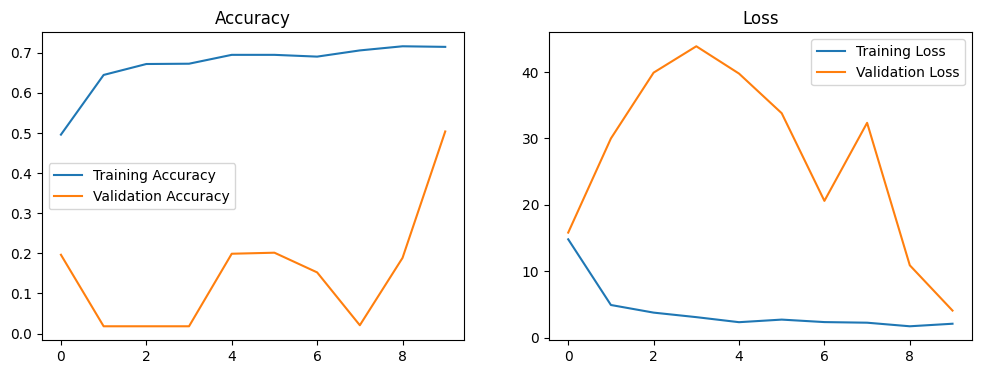

In [24]:
# visualization: CNN Model results

# Plot training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 851ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


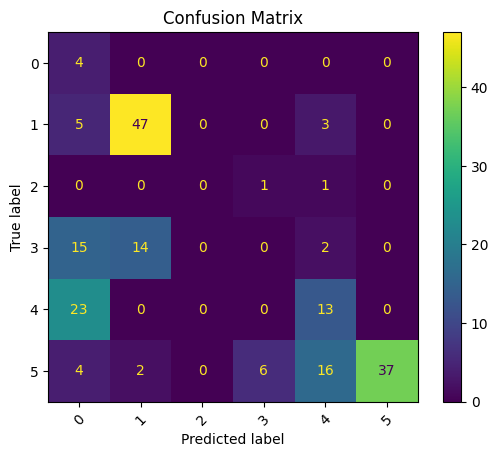

In [25]:
# CONFUSION MATRIX
y_true = []
y_pred = []

for images, labels in test_ds:
  y_true.extend(labels.numpy())
  predictions = cnn_model.predict(images)
  y_pred.extend(np.argmax(predictions, axis=1))

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3, 4, 5])  # Adjust class labels
disp.plot(cmap='viridis', xticks_rotation=45)
plt.title('Confusion Matrix')
plt.show()

#**Transfer Learning**

**Transfer Learning using pretrained model ResNet50**

In [26]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model

In [27]:
# loading the model | ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
base_model.trainable = False
# layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(6, activation='softmax')(x)  # for 6 classes

In [29]:
# craeting model
transfer_model = Model(inputs=base_model.input, outputs=output)
# compiling the model
transfer_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [30]:
transfer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 134, 134, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 32, 32, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 32, 32, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 32, 32, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 32, 32, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 27,782,918 (105.98 MB)

 Trainable params: 4,195,206 (16.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [31]:
# TranferLearning model | Training
history_tl = transfer_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.2926 - loss: 9.5329 - val_accuracy: 0.2661 - val_loss: 2.4442
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 120s 3s/step - accuracy: 0.2955 - loss: 6.8174 - val_accuracy: 0.2687 - val_loss: 2.2832
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 162s 3s/step - accuracy: 0.3324 - loss: 6.2422 - val_accuracy: 0.4238 - val_loss: 2.1980
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.3135 - loss: 6.1994 - val_accuracy: 0.2713 - val_loss: 2.4214
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.3176 - loss: 5.7216 - val_accuracy: 0.3592 - val_loss: 2.2757
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.3312 - loss: 5.6893 - val_accuracy: 0.4703 - val_loss: 2.1543
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 136s 3s/step - accuracy: 0.3881 - loss: 5.4079 - val_accuracy: 0.3359 - val_loss: 2.3765
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.3842 - loss: 5.1462 - val_accuracy: 0.4212 - v

In [32]:
# evalauting model
test_loss, test_accuracy = transfer_model.evaluate(test_ds)
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5060 - loss: 1.8922
Test loss: 1.9845294952392578
Test accuracy: 0.4818652868270874


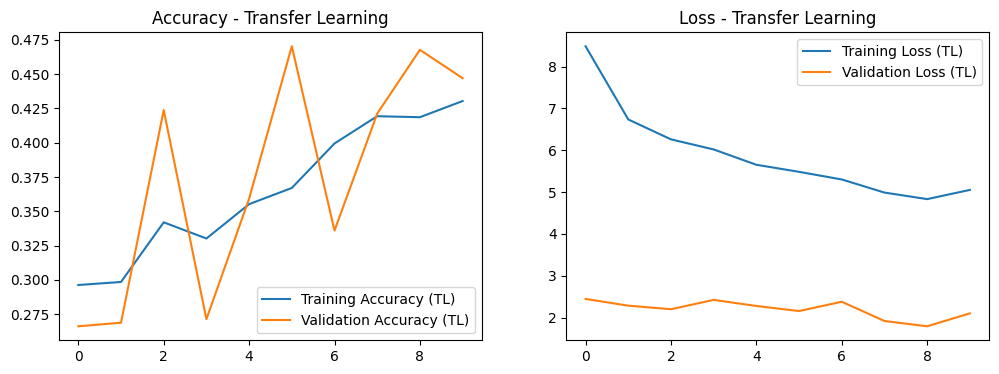

In [33]:
# visualization: TransferLearning Model results
# Plot training & validation accuracy for Transfer Learning
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_tl.history['accuracy'], label='Training Accuracy (TL)')
plt.plot(history_tl.history['val_accuracy'], label='Validation Accuracy (TL)')
plt.legend()
plt.title('Accuracy - Transfer Learning')

# Plot training & validation loss for Transfer Learning
plt.subplot(1, 2, 2)
plt.plot(history_tl.history['loss'], label='Training Loss (TL)')
plt.plot(history_tl.history['val_loss'], label='Validation Loss (TL)')
plt.legend()
plt.title('Loss - Transfer Learning')

plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


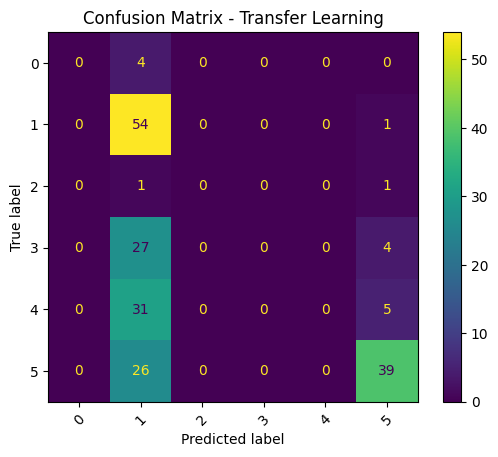

In [34]:
# CONFUSION MATRIX
# Get predictions and true labels from the test dataset for TL
y_true_tl = []
y_pred_tl = []

for images, labels in test_ds:
    y_true_tl.extend(labels.numpy())
    predictions_tl = transfer_model.predict(images)
    y_pred_tl.extend(np.argmax(predictions_tl, axis=1))

# Generate confusion matrix
cm_tl = confusion_matrix(y_true_tl, y_pred_tl)
disp_tl = ConfusionMatrixDisplay(confusion_matrix=cm_tl, display_labels=[0, 1, 2, 3, 4, 5])  # Adjust class labels
disp_tl.plot(cmap='viridis', xticks_rotation=45)
plt.title('Confusion Matrix - Transfer Learning')
plt.show()